In [1]:
import numpy as np
from numpy.fft import rfft, rfftfreq
import sympy as sp
from sympy import fourier_series
import sympy.series
import matplotlib.pyplot as plt
sp.init_printing()
%matplotlib inline

In [2]:
execfile('../matplotlibrc.py')

# Fourier Series

We can represent *every* function as an infinite series of sines and cosines of varying frequencies and amplitude. 
In mathematical terms, given a function $f(x)$, we can write:
$$
f(x) = \frac{1}{2}a_0 \sum_{i=1}^\infty a_n \cos(n x) + b_n \sin(nx)
$$
where $a_n$, $b_n$ are constant coefficients, but depend on the function:
\begin{align}
a_0 &= \frac{1}{\pi}\int_{-\pi}^\pi f(x) dx\\
a_n &= \frac{1}{\pi}\int_{-\pi}^\pi f(x)\cos(nx) dx\\
b_n &= \frac{1}{\pi}\int_{-\pi}^\pi f(x)\sin(nx) dx
\end{align}
Note that the frequency of a wave is the coefficient of $x$ inside the $\cos$ or $\sin$.

## Example

Let:
$$
f(x) = x^3 + x^2 - x
$$
Let's plot that

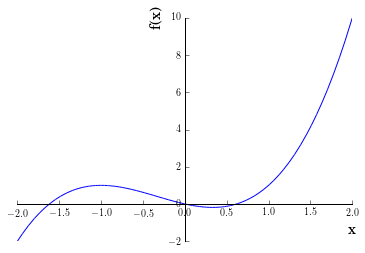

In [3]:
x = sp.symbols('x')
f = x**3  - x + x**2
sp.plot(f, (x, -2, 2))
plt.show()

Now, obviously we can't, and don't want to, use an *infinite* sum. So, instead of going to $\infty$, we go to some arbitrary finite value $N$. This begs the question:

**How many terms do I need to keep?**

Let's find out.

First, let's see what the answer is if we pick $N = 3$.

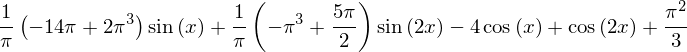

In [4]:
fs = fourier_series(f)
fs.truncate(3)

Now let's plot and compare with the exact $f(x)$ for various $N$. 

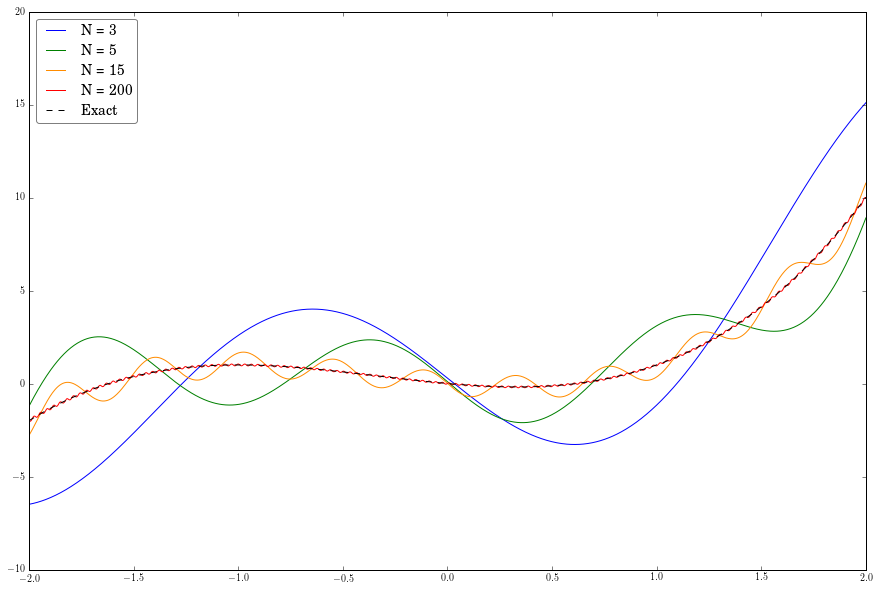

In [5]:
mk_func = lambda y: np.vectorize(sp.lambdify(x, y))
f_dis = mk_func(f)
x_dis = np.linspace(-2, 2, 1000)

fig, ax = plt.subplots(figsize=(15, 10))

all_N = [3, 5, 15, 200]
colors = ['red', 'darkorange', 'green', 'blue']

for N, color in zip(all_N, reversed(colors)):
    approx = mk_func(fs.truncate(N))
    ax.plot(x_dis, approx(x_dis), label='N = %d' % N, color=color)
    
ax.plot(x_dis, f_dis(x_dis), 'k--', label='Exact')
plt.legend()
plt.show()

Why do we care? Because this allows to visualize *any* function or discrete signal (like an audio recording or an image) in the *frequency* domain, as opposed to the *time* domain shown above. Let's look at how the frequency domain can tell us. 

First, let's create a signal made up of sines with varying amplitudes and frequencies

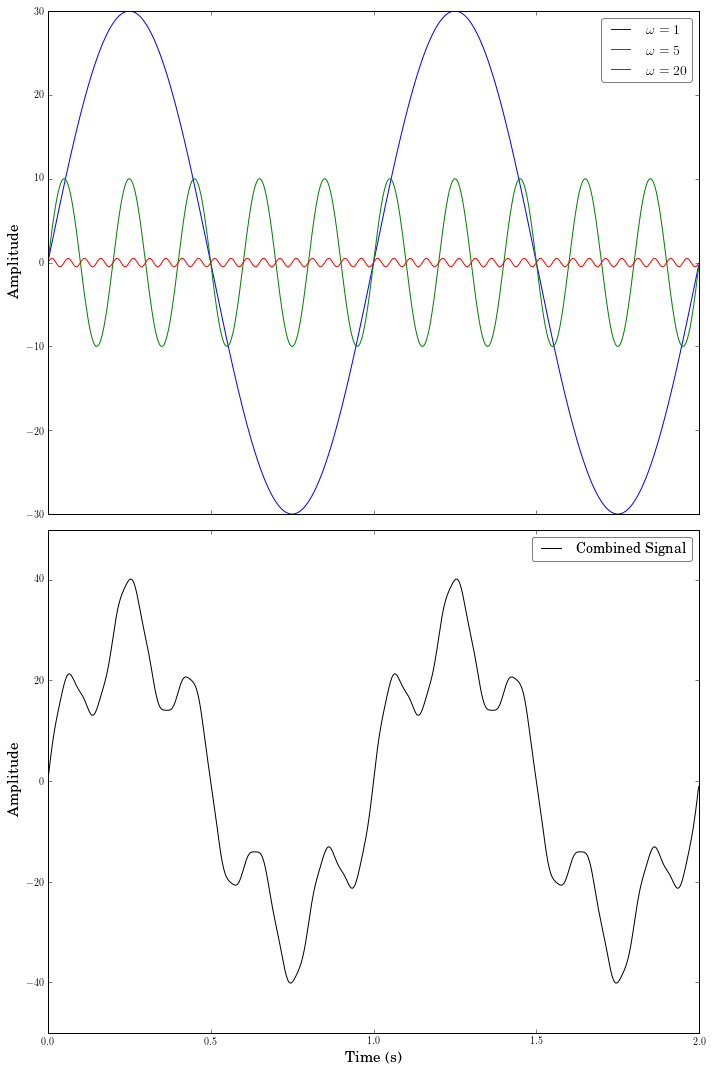

In [6]:
sample_rate = 500
t = np.arange(0, 2, 1.0/sample_rate)
freqs = [1, 5, 20]
amps = [30, 10, 0.5]
fig, (ax_ind, ax_sum) = plt.subplots(nrows=2, sharex=True, figsize=(10, 15))

ax_sum.set_xlabel('Time (s)')
ax_sum.set_ylabel('Amplitude')
ax_ind.set_ylabel('Amplitude')

signal = np.zeros_like(t)
for freq, amp in zip(freqs, amps):
    wave = amp*np.sin(freq*2*np.pi*t)
    ax_ind.plot(t, wave, label=r'$\omega = %.0f$' % freq)
    signal += wave

ax_ind.legend()
ax_sum.plot(t, signal, 'k', label='Combined Signal')
ax_sum.legend()

fig.tight_layout()

Now, using a Fourier Transform, which is a generalized form of the Fourier Series (lots of math). 

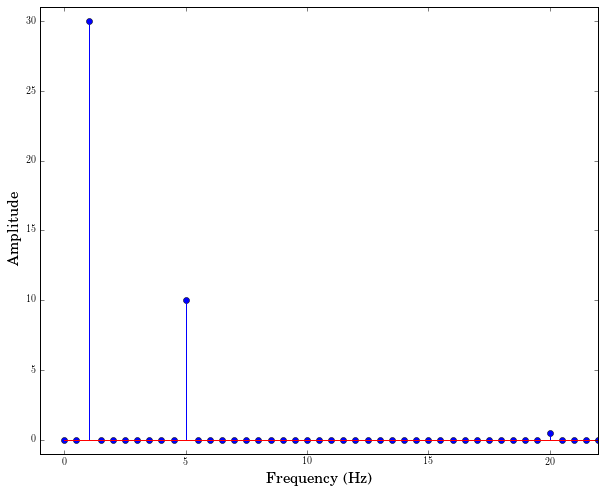

In [7]:
n = signal.size
S = 2*rfft(signal)/n
freq_axis = rfftfreq(n, 1./sample_rate)
fig, ax = plt.subplots(figsize=(10, 8))
ax.stem(freq_axis, np.abs(S))
# ax.s
ax.set_xlim(-1, 22)
ax.set_ylim(-1, 31)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Amplitude')
plt.show()

But this signal is periodic, so it's easy. Typically the dominating frequencies vary over time. This is where frequency spectrum comes in! Let's see what this gives for a C scale on the piano. 

In [8]:
from scipy.io import wavfile

In [10]:
sample_rate, a = wavfile.read('c_scale.wav')
print "The sampling rate is " + str(sample_rate) + " samples per second"
print "There are " + str(len(a)) + " samples in the recording"

The sampling rate is 22050 samples per second
There are 219222 samples in the recording


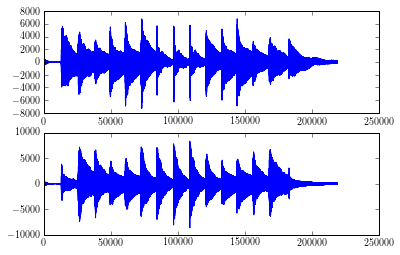

In [11]:
plt.subplot(211)
plt.plot(a[:,0])
plt.subplot(212)
plt.plot(a[:,1])

In [16]:
import scipy.fftpack as fft

/home/selimb/miniconda2/envs/science/lib/python2.7/site-packages/ipykernel/__main__.py:14: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/selimb/miniconda2/envs/science/lib/python2.7/site-packages/ipykernel/__main__.py:19: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


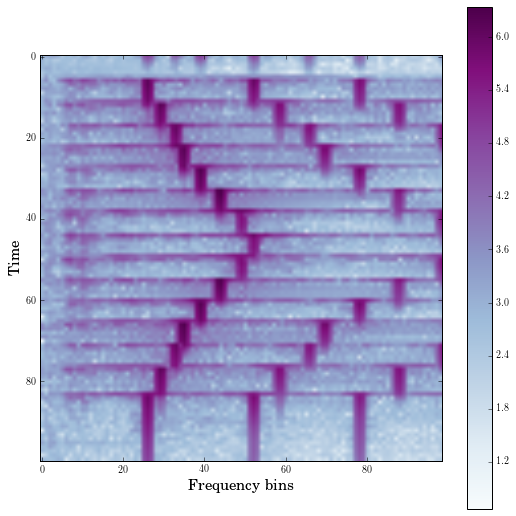

In [17]:
nSlices = 100
slice_width = np.floor(len(signal)/nSlices)
nBins = slice_width
fs = sample_rate/1000.0

maxDispFreq = 1.0    # kHz, since fs is defined in kHz
maxDispBin = np.floor(maxDispFreq/(fs/nBins))    # freq/bin = fs/nBins

spectrogram = np.ones((nSlices,nBins))
fig = plt.figure(figsize=(9,9))
for i in range(nSlices):
    slice_start = i*slice_width
    slice_stop = (i+1)*slice_width
    slice_fft = fft.fft(a[slice_start:slice_stop,0]*np.hamming(slice_width),n = nBins)

    spectrogram[i,:] = np.log10(np.abs(slice_fft))
    

plt.imshow(spectrogram[:,:maxDispBin],cmap="BuPu") 
plt.ylabel('Time')
plt.xlabel('Frequency bins')
plt.colorbar()